In [106]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

from session.sessions import selected_009266
from imports import *
import numpy as np
import h5py
import json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from scipy import stats
from target import build_tgt_matrix
import pandas as pd
from aeps import AEP_metrics_lims, outlier_lims

%matplotlib inline

In [107]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [108]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions[:2]

['009266_hippoSIT_2023-04-17_17-04-17', '009266_hippoSIT_2023-04-18_10-10-37']

In [109]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"

session = sessions[3]

animal     = session.split('_')[0]
meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
units_file = os.path.join(dst_path, animal, session, 'units.h5')
aeps_file  = os.path.join(dst_path, animal, session, 'AEPs.h5')
aeps_c_file = os.path.join(dst_path, animal, session, 'analysis', 'AEP_components.h5')

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    tgt_mx       = np.array(f['processed']['target_matrix'])
    tl           = np.array(f['processed']['timeline'])

AEP_metrics_raw  = {}
AEP_metrics_norm = {}
with h5py.File(aeps_c_file, 'r') as f:
    for area in f:
        AEP_metrics_raw[area] = {}
        AEP_metrics_norm[area] = {}
        for ds_name in f[area]:
            if ds_name.find('raw') > 0:
                AEP_metrics_raw[area][ds_name[:2]] = np.array(f[area][ds_name])
            else:
                AEP_metrics_norm[area][ds_name[:2]] = np.array(f[area][ds_name])

aeps = {}
with h5py.File(aeps_file, 'r') as f:
    for area in f:
        ds_name = [x for x in f[area]][0]
        aeps[area] = np.array(f[area][ds_name])
        
# remove outliers
for area, aeps_mx in aeps.items():
    aeps_no_out = aeps_mx.copy()
    aeps_mx[aeps_mx > outlier_lims[area]]  = outlier_lims[area]
    aeps_mx[aeps_mx < -outlier_lims[area]] = -outlier_lims[area]
    aeps[area] = aeps_no_out
    
session

'009266_hippoSIT_2023-04-19_10-33-51'

In [110]:
# Indices of high / low PPC N1, background only
metric = 'P3'
idxs_bgr = np.where(sound_events[:, 1] == 1)[0]
PPC_N1_mean = AEP_metrics_norm['PPC'][metric][idxs_bgr].mean()
idxs_high = np.where(AEP_metrics_norm['PPC'][metric] > PPC_N1_mean)[0]
idxs_low  = np.where(AEP_metrics_norm['PPC'][metric] < PPC_N1_mean)[0]
idxs_high = np.intersect1d(idxs_high, idxs_bgr)
idxs_low  = np.intersect1d(idxs_low, idxs_bgr)
len(idxs_low), len(idxs_high)

(2886, 2848)

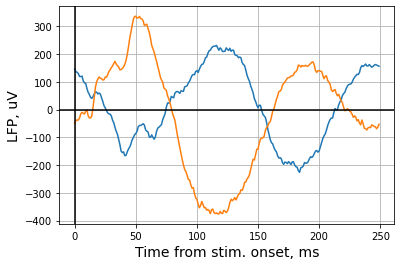

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

#ax.plot(aeps['A1'][idxs_high].mean(axis=0)*0.2)  # 0.2 OpenEphys scaling factor
#ax.plot(aeps['A1'][idxs_low].mean(axis=0)*0.2)  # 0.2 OpenEphys scaling factor
ax.plot(aeps['PPC'][idxs_high].mean(axis=0)*2)  # 0.2 OpenEphys scaling factor
ax.plot(aeps['PPC'][idxs_low].mean(axis=0)*2)  # 0.2 OpenEphys scaling factor
#ax.plot(aeps['PPC'][idxs_bgr].mean(axis=0)*2)  # 0.2 OpenEphys scaling factor
ax.axhline(0, color='black')
ax.axvline(0, color='black')
#ax.legend(loc='upper right', prop={'size': 14})
ax.set_xlabel('Time from stim. onset, ms', fontsize=14)
ax.set_ylabel('LFP, uV', fontsize=14)
#ax.set_title('Evoked Response', fontsize=14)
#ax.set_ylim(-50, 50)
ax.grid()
#for j, (key, value) in enumerate(AEP_metrics_lims[area].items()):
#    ax.axvline(value[0], color='black', ls='--', lw=1)
#    ax.axvline(value[1], color='black', ls='--', lw=1)

## Progression

In [112]:
metric = 'N1'
idxs_sort = np.argsort(AEP_metrics_norm['PPC'][metric][idxs_bgr])

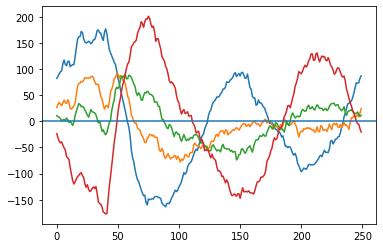

In [113]:
bin_count = 5
bins = np.linspace(0, len(idxs_sort), bin_count)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(bin_count - 1):  # number of bins
    idx_l, idx_r = int(bins[i]), int(bins[i+1])
    ax.plot(aeps['PPC'][idxs_bgr][idxs_sort][idx_l:idx_r].mean(axis=0))
ax.axhline(0)

## Run / sit (good AEP when sitting)

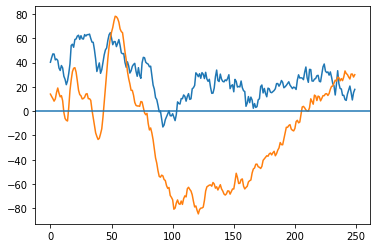

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

idxs_run = np.where(tl[sound_events[:, 2].astype(np.int32)][:, 3] > 0.04)[0]
idxs_sit = np.where(tl[sound_events[:, 2].astype(np.int32)][:, 3] < 0.04)[0]
idxs_run = np.intersect1d(idxs_run, idxs_bgr)
idxs_sit = np.intersect1d(idxs_sit, idxs_bgr)
len(idxs_sit), len(idxs_run)

area = 'PPC'
ax.plot(aeps[area][idxs_run].mean(axis=0))
ax.plot(aeps[area][idxs_sit].mean(axis=0))
ax.axhline(0)